Environment preparation

In [1]:
# Cài đặt các thư viện cần thiết
!pip install torch torchvision numpy matplotlib opencv-python scikit-learn

In [2]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Cấu hình device (GPU nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Tạo nhãn chất lượng giả từ hình ảnh siêu âm
def generate_variants(image_path, output_dir):
    img = cv2.imread(image_path)
    base_name = os.path.basename(image_path).split('.')[0]

    labels = []
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # High quality (original)
    high_quality_path = os.path.join(output_dir, f"{base_name}_high.jpg")
    cv2.imwrite(high_quality_path, img)
    labels.append((high_quality_path, 100))  # Gán nhãn 100

    # Medium quality (JPEG compression)
    medium_quality_path = os.path.join(output_dir, f"{base_name}_medium.jpg")
    cv2.imwrite(medium_quality_path, img, [cv2.IMWRITE_JPEG_QUALITY, 50])
    labels.append((medium_quality_path, 60))  # Gán nhãn 60

    # Low quality (Gaussian blur)
    low_quality_path = os.path.join(output_dir, f"{base_name}_low.jpg")
    blurred = cv2.GaussianBlur(img, (15, 15), 10)
    cv2.imwrite(low_quality_path, blurred)
    labels.append((low_quality_path, 30))  # Gán nhãn 30

    return labels

def preprocess_images(input_dir, output_dir):
    all_labels = []
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_dir, filename)
            try:
                labels = generate_variants(image_path, output_dir)
                all_labels.extend(labels)
            except Exception as e:
                print(f"Lỗi xử lý ảnh {image_path}: {e}")
    return all_labels


In [4]:
# Tạo class Dataset cho PyTorch
class UltrasoundDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Chia dữ liệu thành tập huấn luyện, kiểm định, kiểm tra
def split_dataset(all_labels):
    image_paths, labels = zip(*all_labels)
    train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
    train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, random_state=42)
    return train_paths, val_paths, test_paths, train_labels, val_labels, test_labels

# Chuẩn bị dữ liệu và DataLoader
def prepare_dataloader(image_paths, labels, transform, batch_size=16):
    dataset = UltrasoundDataset(image_paths, labels, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


In [5]:
import torch.nn as nn

# ResNet với đầu ra là một giá trị liên tục
class QualityAssessmentModel(nn.Module):
    def __init__(self):
        super(QualityAssessmentModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)  # Output là một giá trị liên tục

    def forward(self, x):
        return self.resnet(x)


In [6]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model, train_losses, val_losses


In [10]:
def evaluate_model(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            true_labels.extend(labels.cpu().numpy())
            # Reshape the predicted labels to 1D
            predicted_labels.extend(outputs.cpu().numpy().flatten())

    mse = mean_squared_error(true_labels, predicted_labels)
    lcc = np.corrcoef(true_labels, predicted_labels)[0, 1]
    return mse, lcc


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Đường dẫn thư mục
input_dir = "/content/drive/MyDrive/2024.1 DIP/DIP PROJECT/Train"  # Thư mục chứa ảnh gốc
output_dir = "/content/preprocessed_images"

import os

print("Danh sách ảnh trong thư mục:")
print(os.listdir(input_dir))


# Tạo dữ liệu với nhãn giả
all_labels = preprocess_images(input_dir, output_dir)

# Chia dữ liệu
train_paths, val_paths, test_paths, train_labels, val_labels, test_labels = split_dataset(all_labels)

# Transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataloader
train_loader = prepare_dataloader(train_paths, train_labels, transform)
val_loader = prepare_dataloader(val_paths, val_labels, transform)
test_loader = prepare_dataloader(test_paths, test_labels, transform)

# Khởi tạo mô hình
model = QualityAssessmentModel()

# Huấn luyện
model, train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001)

# Đánh giá
mse, lcc = evaluate_model(model, test_loader)
print(f"Test MSE: {mse:.4f}, Test LCC: {lcc:.4f}")


Danh sách ảnh trong thư mục:
['benign (289)-rotated2.png', 'benign (289).png', 'benign (288)-rotated2-sharpened.png', 'benign (288)-rotated2.png', 'benign (290)-rotated1-sharpened.png', 'benign (289)-sharpened.png', 'benign (288)-sharpened.png', 'benign (290)-sharpened.jpg', 'benign (287)-sharpened.png', 'benign (288)-sharpened-rotated2.png', 'benign (287)-sharpened-sharpened.png', 'benign (290)-rotated1-rotated1.png', 'benign (288)-rotated1-sharpened.png', 'benign (289)-sharpened-rotated2.png', 'benign (289)-rotated1-rotated2.png', 'benign (289)-sharpened-sharpened.png', 'benign (289)-rotated2-rotated2.png', 'benign (287)-sharpened.jpg', 'benign (290)-sharpened.png', 'benign (290)-rotated1.png', 'benign (289)-rotated1.jpg', 'benign (288)-rotated1.jpg', 'benign (290)-rotated1-rotated2.png', 'benign (288)-rotated2.jpg', 'benign (288)-rotated1-rotated1.png', 'benign (290)-rotated2-sharpened.png', 'benign (290)-rotated2.jpg', 'benign (290)-sharpened-rotated1.png', 'benign (289)-rotated2-s

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 4439.4790, Val Loss: 11303.5947
Epoch 2/10, Train Loss: 3760.4777, Val Loss: 4933.8562
Epoch 3/10, Train Loss: 3561.1294, Val Loss: 4395.0040
Epoch 4/10, Train Loss: 2973.2284, Val Loss: 2439.2838
Epoch 5/10, Train Loss: 2561.7564, Val Loss: 2585.3831
Epoch 6/10, Train Loss: 2176.6289, Val Loss: 2614.2668
Epoch 7/10, Train Loss: 1852.0308, Val Loss: 1555.3004
Epoch 8/10, Train Loss: 1518.2147, Val Loss: 1465.0002
Epoch 9/10, Train Loss: 1227.8200, Val Loss: 1144.8590
Epoch 10/10, Train Loss: 1035.3842, Val Loss: 854.9028
Test MSE: 859.2369, Test LCC: 0.9299


In [17]:
import matplotlib.pyplot as plt

def visualize_image_quality(image, predicted_quality):
    plt.imshow(image.permute(1, 2, 0))  # Chuyển tensor thành hình ảnh
    plt.title(f"Predicted Quality: {predicted_quality:.2f}")
    plt.axis("off")
    plt.show()

for images, labels in test_loader:
    outputs = model(images.to(device)).cpu().detach().numpy()
    for i, predicted_quality in enumerate(outputs):
        visualize_image_quality(images[i], predicted_quality[0])


Output hidden; open in https://colab.research.google.com to view.

Test MSE: 859.2369, Test LCC: 0.9299


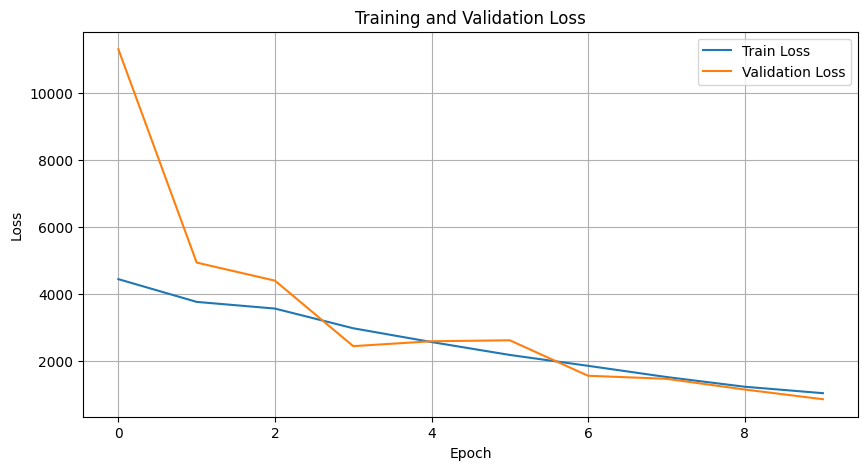

In [18]:
# prompt: vẽ biểu đồ đánh giá model

import matplotlib.pyplot as plt

# ... (your existing code)

# Đánh giá
mse, lcc = evaluate_model(model, test_loader)
print(f"Test MSE: {mse:.4f}, Test LCC: {lcc:.4f}")

# Vẽ biểu đồ Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ MSE và LCC (nếu cần)
# plt.figure(figsize=(10, 5))
# plt.plot([mse], label='Test MSE', marker='o')
# plt.plot([lcc], label='Test LCC', marker='o')
# plt.xlabel('Metrics')
# plt.ylabel('Values')
# plt.title('Model Evaluation Metrics')
# plt.legend()
# plt.grid(True)
# plt.show()

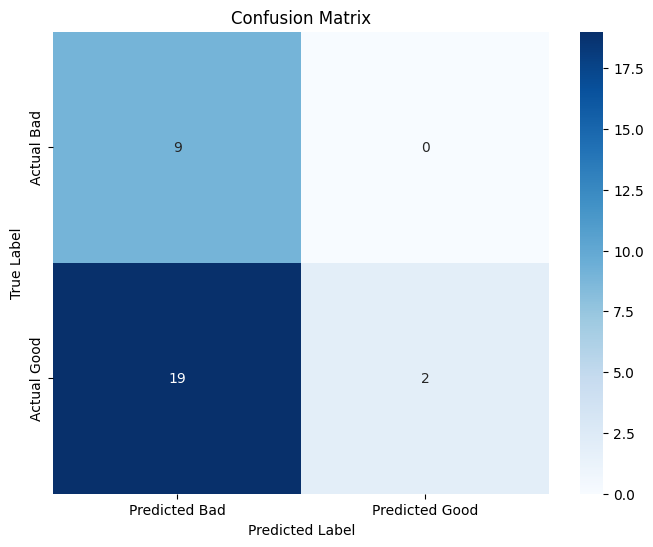

Test MSE: 859.2369, Test LCC: 0.9299


In [19]:
# prompt: vẽ thêm confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, threshold=60): # Added threshold parameter
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(outputs.cpu().numpy().flatten())

    # Convert to binary classification based on threshold
    true_binary = [1 if x >= threshold else 0 for x in true_labels] #  >=60 is good quality
    predicted_binary = [1 if x >= threshold else 0 for x in predicted_labels]

    mse = mean_squared_error(true_labels, predicted_labels)
    lcc = np.corrcoef(true_labels, predicted_labels)[0, 1]

    # Confusion Matrix
    cm = confusion_matrix(true_binary, predicted_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Bad", "Predicted Good"],
                yticklabels=["Actual Bad", "Actual Good"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return mse, lcc

# ... (rest of your code)

# Đánh giá (với hàm đã sửa đổi)
mse, lcc = evaluate_model(model, test_loader) # Use default threshold of 60
print(f"Test MSE: {mse:.4f}, Test LCC: {lcc:.4f}")

In [16]:
def predict_image_quality(model, image_path, transform):
    """
    Predicts the quality of a single ultrasound image.

    Args:
        model: The trained quality assessment model.
        image_path: Path to the ultrasound image.
        transform: The image transformations to apply (same as during training).

    Returns:
        The predicted quality score (a floating-point number).
    """

    # 1. Load and Preprocess the Image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)

    # 2. Make the Prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        output = model(image)
        predicted_quality = output.item()  # Get the predicted score

    return predicted_quality


# Example usage:
image_path_to_predict = "/content/drive/MyDrive/2024.1 DIP/DIP PROJECT/rezized_ct8-8.png"  # Replace with the actual path
predicted_quality = predict_image_quality(model, image_path_to_predict, transform)

print(f"Predicted Quality: {predicted_quality:.2f}")

# You can add logic to interpret the predicted quality score:
if predicted_quality > 80:
    print("Image Quality: High")
elif predicted_quality > 50:
    print("Image Quality: Medium")
else:
    print("Image Quality: Low")

Predicted Quality: 53.05
Image Quality: Medium
